In [151]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFECV
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier



In [152]:
data = pd.read_csv("full_dataset.csv", index_col=0)
X = data.drop(columns=["label"])
y = data["label"]
X.shape[0]

211028

we have 211028 data samples, that's too much for feature selection, we will take just a stratisfied (because classes are imbalanced) subset of it (12k samples)

In [153]:
X_train, _, y_train, _ = train_test_split(X, y, random_state=42, stratify=y, train_size=15000)

we will start by some naive variance selection

In [154]:
X_train.var()

mfcc1_mean                   2039.955579
mfcc2_mean                   1858.889357
mfcc3_mean                    796.850486
mfcc4_mean                    613.083484
mfcc5_mean                    432.441881
mfcc6_mean                    244.616224
mfcc7_mean                    209.558196
mfcc8_mean                    169.868631
d_mfcc1_mean                    6.125411
d_mfcc2_mean                    4.959262
d_mfcc3_mean                    1.592547
d_mfcc4_mean                    1.183822
d_mfcc5_mean                    0.655211
d_mfcc6_mean                    0.422298
d_mfcc7_mean                    0.330937
d_mfcc8_mean                    0.271615
dd_mfcc1_mean                   1.661229
dd_mfcc2_mean                   0.733354
dd_mfcc3_mean                   0.278490
dd_mfcc4_mean                   0.183769
dd_mfcc5_mean                   0.132407
dd_mfcc6_mean                   0.089262
dd_mfcc7_mean                   0.074103
dd_mfcc8_mean                   0.065141
spectral_centroi

the scales are different, so variance is not really comparable, we will scale first using minmax

In [155]:
mm_scaler = MinMaxScaler()
X_train_sc = mm_scaler.fit_transform(X_train) 



<BarContainer object of 60 artists>

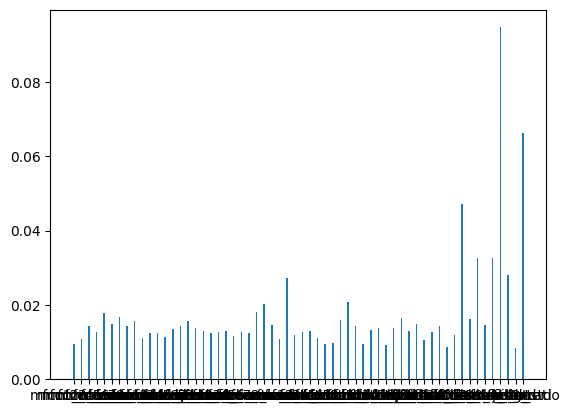

In [156]:
fig, axe = plt.subplots()
axe.bar(X.columns, X_train_sc.var(axis=0), width=0.2)

In [157]:
X_train_sc.var(axis=0).mean()

np.float64(0.017176962487695593)

we will continue experimenting with the 30 features selected by variance threshold

In [158]:
threshold = 0.014
var_selector = VarianceThreshold(threshold=threshold)
var_selector.fit(X_train_sc)

,"threshold threshold: float, default=0Features with a training-set variance lower than this threshold willbe removed. The default is to keep all features with non-zero variance,i.e. remove the features that have the same value in all samples.",0.014


In [159]:
var_mask = var_selector.get_support()
var_selected_X = X_train[np.array(X_train.columns)[var_mask]]
var_selected_X.head()

,mfcc3_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,d_mfcc1_mean,d_mfcc7_mean,d_mfcc8_mean,spectral_centroid_mean,spectral_bandwidth_mean,...,dd_mfcc3_std,dd_mfcc6_std,spectral_centroid_std,spectral_bandwidth_std,f0_frame_std,f0_mean_stat,f0_std_stat,f0_range,jitter,f1_f2_ratio
58265,31.724730,7.582926,-4.546176,-1.072956,-20.587051,3.336089,0.507752,-0.282888,819.19055,1156.49610,...,2.401188,2.083025,423.48820,407.71370,88.053950,134.080830,88.053950,345.066280,0.061826,0.000000
102807,8.250049,15.484197,9.583971,14.298329,-17.613926,-3.100937,-0.179245,-0.772942,935.00790,1094.04330,...,3.265928,1.971593,835.81020,357.37192,108.942580,141.119370,108.942570,448.242740,0.332095,0.000000
186669,30.717876,17.088343,-8.334359,7.049521,-5.788708,-2.956965,0.332071,-0.287873,604.53060,893.39170,...,2.873813,1.148112,324.53513,375.98970,8.964994,97.565630,8.964995,43.296562,0.034696,0.517555
78905,-43.011350,-26.532227,-17.405645,1.145925,-24.857930,-2.605079,0.394826,-0.485746,1461.02820,1113.72030,...,6.161303,2.988202,687.61615,306.65234,103.287530,171.890530,103.287530,445.117370,0.277533,0.000000
96896,11.194218,23.748663,2.529528,-6.827323,-16.181160,0.696544,-0.582680,0.182738,499.36002,631.60077,...,3.076271,2.002594,169.39313,268.11017,24.646225,113.734116,24.646225,154.731110,0.091737,0.000000


cross validated evaluation with xgboost classifier

In [160]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1
)


In [161]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
}


ROC-AUC score for the selected features and for original features to evaluate the selection: 

In [162]:
sel_results = cross_validate(
    model,
    var_selected_X,   #the 30 selected features using variance
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
orig_results = cross_validate(
    model,
    X_train,   #all original features
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("original features:")
print("ROC-AUC:", orig_results["test_roc_auc"].mean())

print("selected features:")
print("ROC-AUC:", sel_results["test_roc_auc"].mean())


original features:
ROC-AUC: 0.649368381311568
selected features:
ROC-AUC: 0.6489224252376673


we tested different thresholds, and 0.014 is the optimal one, it kept only 26 features (from 60) with 0.001 less ROC-AUC

In [163]:
mi_selector = SelectKBest(score_func=mutual_info_classif, k=20)
mi_selector.fit(var_selected_X, y_train)
mi_selected_X = var_selected_X[var_selected_X.columns[mi_selector.get_support()]]
mi_selected_X.head()



,mfcc3_mean,mfcc5_mean,d_mfcc8_mean,spectral_centroid_mean,spectral_bandwidth_mean,f0_frame_mean,d_mfcc1_std,d_mfcc2_std,d_mfcc3_std,dd_mfcc1_std,dd_mfcc3_std,dd_mfcc6_std,spectral_centroid_std,spectral_bandwidth_std,f0_frame_std,f0_mean_stat,f0_std_stat,f0_range,jitter,f1_f2_ratio
58265,31.724730,7.582926,-0.282888,819.19055,1156.49610,134.080830,11.922284,7.028588,4.753977,6.117466,2.401188,2.083025,423.48820,407.71370,88.053950,134.080830,88.053950,345.066280,0.061826,0.000000
102807,8.250049,15.484197,-0.772942,935.00790,1094.04330,141.119370,13.323623,10.129259,5.522694,5.316749,3.265928,1.971593,835.81020,357.37192,108.942580,141.119370,108.942570,448.242740,0.332095,0.000000
186669,30.717876,17.088343,-0.287873,604.53060,893.39170,97.565620,15.065388,5.160717,6.239866,6.293956,2.873813,1.148112,324.53513,375.98970,8.964994,97.565630,8.964995,43.296562,0.034696,0.517555
78905,-43.011350,-26.532227,-0.485746,1461.02820,1113.72030,171.890530,11.718758,10.336090,7.388339,12.471118,6.161303,2.988202,687.61615,306.65234,103.287530,171.890530,103.287530,445.117370,0.277533,0.000000
96896,11.194218,23.748663,0.182738,499.36002,631.60077,113.734116,9.067464,5.652665,4.431202,5.455367,3.076271,2.002594,169.39313,268.11017,24.646225,113.734116,24.646225,154.731110,0.091737,0.000000


we kept the 20 top features selected by mutual info, we will evaluate against the 26 selected by variance threshold

In [164]:
sel_results = cross_validate(
    model,
    mi_selected_X,   #the 20 selected features using mutual info from the 26 features selected by variance
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)


print("selected features:")
print("ROC-AUC:", sel_results["test_roc_auc"].mean())

orig_results = cross_validate(
    model,
    var_selected_X,   #26 features selected by variance 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("original features:")
print("ROC-AUC:", orig_results["test_roc_auc"].mean())


selected features:
ROC-AUC: 0.6153040665716978
original features:
ROC-AUC: 0.6489224252376673


applying mutual info on the variance selected features gives bad scores, I also tried mutual info alone with k=26 (like the number chosen by variance threshold) and it gave worse results, so variance threshold is the best so far.
for a last trick, I will try RFECV on all the original features to see if it would give better results than what we got so far.  

In [165]:
rfecv_selector = RFECV(estimator=model, min_features_to_select=20, n_jobs=-1, cv=cv)
rfecv_selector.fit(X_train, y_train)
rfecv_selected_X = X_train[X_train.columns[rfecv_selector.get_support()]]
rfecv_selected_X.head()

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,d_mfcc1_mean,spectral_centroid_mean,...,mfcc2_std,mfcc7_std,d_mfcc4_std,d_mfcc8_std,dd_mfcc2_std,dd_mfcc3_std,dd_mfcc4_std,f0_frame_std,f0_mean_stat,f1_f2_ratio
58265,-291.38300,144.70330,31.724730,50.832733,7.582926,-4.546176,-1.072956,-20.587051,3.336089,819.19055,...,40.443844,15.596282,5.548144,3.505395,4.002732,2.401188,2.785862,88.053950,134.080830,0.000000
102807,-369.00280,144.52643,8.250049,39.441147,15.484197,9.583971,14.298329,-17.613926,-3.100937,935.00790,...,61.329853,15.155898,4.010964,4.626319,3.446539,3.265928,1.799882,108.942580,141.119370,0.000000
186669,-418.04987,180.66788,30.717876,54.620155,17.088343,-8.334359,7.049521,-5.788708,-2.956965,604.53060,...,32.037525,14.829449,4.620185,1.346352,3.279188,2.873813,2.322776,8.964994,97.565630,0.517555
78905,-368.81250,136.86998,-43.011350,64.565414,-26.532227,-17.405645,1.145925,-24.857930,-2.605079,1461.02820,...,65.391170,25.428400,9.637752,3.727547,4.649344,6.161303,5.082736,103.287530,171.890530,0.000000
96896,-410.45316,219.15575,11.194218,22.452381,23.748663,2.529528,-6.827323,-16.181160,0.696544,499.36002,...,40.157944,18.689255,4.745102,2.993803,3.904594,3.076271,2.017153,24.646225,113.734116,0.000000


In [166]:
sel_results = cross_validate(
    model,
    rfecv_selected_X,   #the selected features using RFCV
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)


print("rfecv selected features:")
print("ROC-AUC:", sel_results["test_roc_auc"].mean())

orig_results = cross_validate(
    model,
    var_selected_X,   #26 features selected by variance 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("variance threshold selected features:")
print("ROC-AUC:", orig_results["test_roc_auc"].mean())


rfecv selected features:
ROC-AUC: 0.6810372648252784
variance threshold selected features:
ROC-AUC: 0.6489224252376673


Good! RFECV kept less features (23) than variance threshold (26), moreover it improved ROC-AUC score by 4% instead of dropping it. 
we will now fine tune the xgboost model using the 23 selected features.

In [ ]:
final_data = X[X.columns[rfecv_selector.get_support()]]
print("final selected features: ", final_data.columns.tolist())
final_data["label"] = y

final_data.to_csv("selected_features.csv", index=False)

#save the features mask to apply on inference audios vectors 
import joblib
features_mask = rfecv_selector.get_support()
joblib.dump(features_mask, "model/features_mask.joblib")



final selected features:  ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'd_mfcc1_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 'f0_frame_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc7_std', 'd_mfcc4_std', 'd_mfcc8_std', 'dd_mfcc2_std', 'dd_mfcc3_std', 'dd_mfcc4_std', 'f0_frame_std', 'f0_mean_stat', 'f1_f2_ratio']


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\2808129858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data["label"] = y


['features_mask.joblib']